In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline
import seaborn as sns

from scipy.stats import boxcox, probplot
import matplotlib.pyplot as plt

import dask.dataframe as dd
import datetime
from datetime import date

In [2]:
data_test = pd.read_csv('data_test.csv')
data_train = pd.read_csv('data_train.csv')

In [3]:
data_train = data_train.drop(['Unnamed: 0'],axis=1)

In [4]:
#features = dd.read_csv('features.csv', sep='\t')
#data = dd.merge(data_train, features, on = 'id')

In [5]:
features = pd.read_csv('features.csv', sep='\t')

In [6]:
features = features.drop(['Unnamed: 0'],axis=1)

In [7]:
data_train['date'] =  data_train['buy_time'].apply(lambda x: date.fromtimestamp(x))

In [8]:
features['date'] =  features['buy_time'].apply(lambda x: date.fromtimestamp(x))

In [9]:
print("ID уникален? ", data_train.id.is_unique)
print("Есть ли дубли в строках?", data_train.duplicated().sum())
print("Сколько процент признаков могут принимать null-значениями? %d%%" % float((data_train.isnull().sum() > 0).sum()/data_train.shape[1]*100))

ID уникален?  False
Есть ли дубли в строках? 0
Сколько процент признаков могут принимать null-значениями? 0%


In [10]:
dubl_train = pd.DataFrame(data_train[['id', 'vas_id', 'buy_time']].groupby(['id', 'vas_id', 'buy_time']).value_counts()).rename(columns = {0:'count'}).reset_index()
dubl_train.loc[(dubl_train['count'] > 1)].head()

,id,vas_id,buy_time,count


In [11]:
print("ID уникален? ", features.id.is_unique)
print("Есть ли дубли в строках?", features.duplicated().sum())
print("Сколько процент признаков могут принимать null-значениями? %d%%" % float((features.isnull().sum() > 0).sum()/features.shape[1]*100))

ID уникален?  False
Есть ли дубли в строках? 0
Сколько процент признаков могут принимать null-значениями? 0%


In [12]:
X = data_train.drop(['target'],axis=1)
y = (data_train['target'])

0.0    0.927631
1.0    0.072369
Name: target, dtype: float64

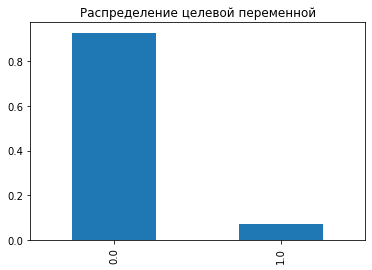

In [13]:
(y.value_counts()/y.shape[0]).plot(kind='bar', title='Распределение целевой переменной');
y.value_counts()/y.shape

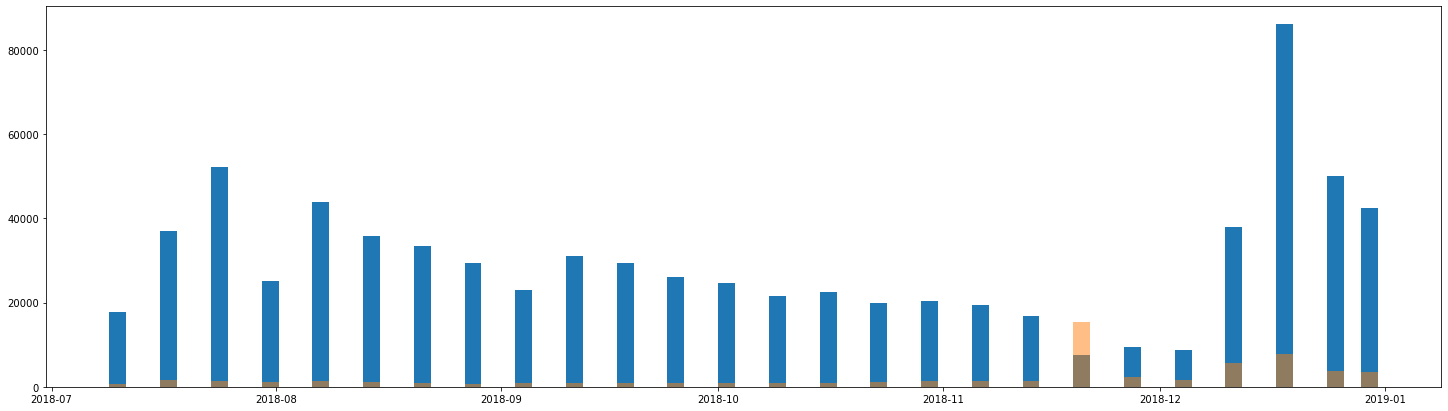

In [14]:
plt.figure(figsize=(25,7))
plt.hist(data_train.loc[(data_train['target']==0, 'date')], bins=75)
plt.hist(data_train.loc[(data_train['target']==1, 'date')], bins=75, alpha=0.5)
plt.show()

Видно где-то в середине ноября высокий спрос на приобретение услуг, видимо были какие-то выгодые условия.
Также видно, что актививзировалось кол-во предложений в декабре-январе, видимо в связи с новогодними праздниками.

In [15]:
data_train.vas_id.value_counts()

1.0    310175
2.0    249505
5.0     94085
4.0     85756
6.0     57878
7.0     15432
8.0     13350
9.0      5472
Name: vas_id, dtype: int64

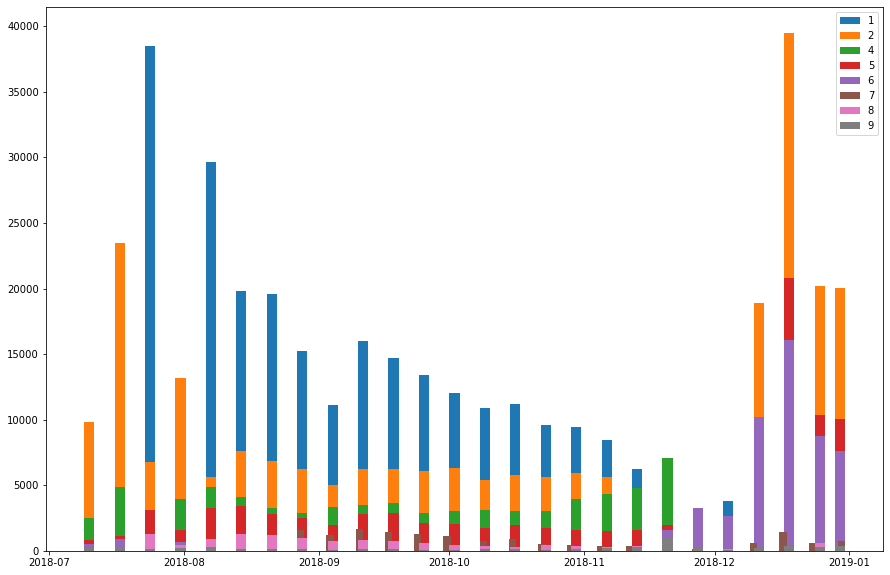

In [25]:
plt.figure(figsize=(15,10))

kwargs = dict(bins=75, stacked=True)

plt.hist(pd.DataFrame(data_train.loc[(data_train['vas_id'] == 1.0), ['id', 'date']]).set_index('id').rename_axis(None).iloc[:,0], **kwargs, label='1')
plt.hist(pd.DataFrame(data_train.loc[(data_train['vas_id'] == 2.0), ['id', 'date']]).set_index('id').rename_axis(None).iloc[:,0], **kwargs, label='2')
#plt.hist(pd.DataFrame(data_train.loc[(data_train['vas_id'] == 3.0), ['id', 'date']]).set_index('id').rename_axis(None).iloc[:,0], **kwargs, label='3')
plt.hist(pd.DataFrame(data_train.loc[(data_train['vas_id'] == 4.0), ['id', 'date']]).set_index('id').rename_axis(None).iloc[:,0], **kwargs, label='4')
plt.hist(pd.DataFrame(data_train.loc[(data_train['vas_id'] == 5.0), ['id', 'date']]).set_index('id').rename_axis(None).iloc[:,0], **kwargs, label='5')
plt.hist(pd.DataFrame(data_train.loc[(data_train['vas_id'] == 6.0), ['id', 'date']]).set_index('id').rename_axis(None).iloc[:,0], **kwargs, label='6')
plt.hist(pd.DataFrame(data_train.loc[(data_train['vas_id'] == 7.0), ['id', 'date']]).set_index('id').rename_axis(None).iloc[:,0], **kwargs, label='7')
plt.hist(pd.DataFrame(data_train.loc[(data_train['vas_id'] == 8.0), ['id', 'date']]).set_index('id').rename_axis(None).iloc[:,0], **kwargs, label='8')
plt.hist(pd.DataFrame(data_train.loc[(data_train['vas_id'] == 9.0), ['id', 'date']]).set_index('id').rename_axis(None).iloc[:,0], **kwargs, label='9')


plt.legend()
plt.show()

Видно, что чаще всего предлагаются услуги 1 и 2. На новогодние праздники активно предлагали услугу 6.

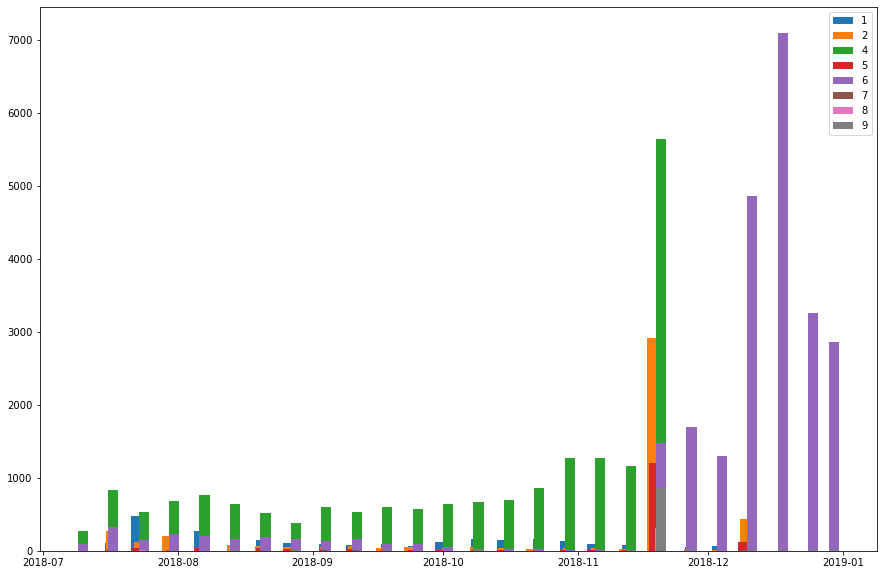

In [26]:
plt.figure(figsize=(15,10))

kwargs = dict(bins=75, stacked=True)

plt.hist(pd.DataFrame(data_train.loc[(data_train['vas_id'] == 1.0) & (data_train['target'] == 1), ['id', 'date']]).set_index('id').rename_axis(None).iloc[:,0], **kwargs, label='1')
plt.hist(pd.DataFrame(data_train.loc[(data_train['vas_id'] == 2.0) & (data_train['target'] == 1), ['id', 'date']]).set_index('id').rename_axis(None).iloc[:,0], **kwargs, label='2')
#plt.hist(pd.DataFrame(data_train.loc[(data_train['vas_id'] == 3.0) & (data_train['target'] == 1), ['id', 'date']]).set_index('id').rename_axis(None).iloc[:,0], **kwargs, label='3')
plt.hist(pd.DataFrame(data_train.loc[(data_train['vas_id'] == 4.0) & (data_train['target'] == 1), ['id', 'date']]).set_index('id').rename_axis(None).iloc[:,0], **kwargs, label='4')
plt.hist(pd.DataFrame(data_train.loc[(data_train['vas_id'] == 5.0) & (data_train['target'] == 1), ['id', 'date']]).set_index('id').rename_axis(None).iloc[:,0], **kwargs, label='5')
plt.hist(pd.DataFrame(data_train.loc[(data_train['vas_id'] == 6.0) & (data_train['target'] == 1), ['id', 'date']]).set_index('id').rename_axis(None).iloc[:,0], **kwargs, label='6')
plt.hist(pd.DataFrame(data_train.loc[(data_train['vas_id'] == 7.0) & (data_train['target'] == 1), ['id', 'date']]).set_index('id').rename_axis(None).iloc[:,0], **kwargs, label='7')
plt.hist(pd.DataFrame(data_train.loc[(data_train['vas_id'] == 8.0) & (data_train['target'] == 1), ['id', 'date']]).set_index('id').rename_axis(None).iloc[:,0], **kwargs, label='8')
plt.hist(pd.DataFrame(data_train.loc[(data_train['vas_id'] == 9.0) & (data_train['target'] == 1), ['id', 'date']]).set_index('id').rename_axis(None).iloc[:,0], **kwargs, label='9')


plt.legend()
plt.show()

Видно, что хоть чаще всего предлагают услуги 1 и 2, однако наиболее популярна услуга 4. Собсвтенно всплеск в середине ноября обусловлен приобретением данных услуг.
Также услуга, предлагаемая в новогодние праздники (6) имеет хороший отклик среди клиентов. Можно предположить, что на нее дейтсвует новогодняя скидка и условия довольно выгодные.

Объеденим наш трейновый датасет с данными признаков:

In [18]:
data_train = data_train.sort_values(by="buy_time")
features = features.sort_values(by="buy_time")

In [183]:
data = data_train.merge(features, on=['id'], how = 'left')

In [184]:
print("Сколько процент признаков могут принимать null-значениями? %d%%" % float((data.isnull().sum() > 0).sum()/data.shape[1]*100))

Сколько процент признаков могут принимать null-значениями? 0%


In [185]:
data.head(2)

,id,vas_id,buy_time_x,target,date_x,buy_time_y,0,1,2,3,...,244,245,246,247,248,249,250,251,252,date_y
0,2582523,2.0,1531083600,0.0,2018-07-09,1544994000,314.560029,9.290888,342.989214,7.523202,...,-574.770792,-24.996269,121.369552,142.252276,-16.832889,-0.694428,-11.175933,-0.45614,0.0,2018-12-17
1,1292549,2.0,1531083600,0.0,2018-07-09,1537131600,93.880029,-217.499112,79.939214,-270.106798,...,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0,2018-09-17


Следует учесть дату предложения услуги. Если по данным датасета с фичами услугу предложили после принятия или отказа, то сделаует очистить такие строки.

In [186]:
data['not_correct'] = data.apply(lambda x: 1 if x['buy_time_y'] >= x['buy_time_x'] else 0, axis=1)

In [187]:
data['not_correct'].value_counts()

1    482661
0    377391
Name: not_correct, dtype: int64

Видно, что довольно много откликов не идентифицировано в датасете с фичами. 

In [188]:
col_n_cor = list(data.iloc[:,5:].columns)

In [189]:
data.loc[data['not_correct'] == 1, col_n_cor] = 0

In [190]:
data.head(2)

,id,vas_id,buy_time_x,target,date_x,buy_time_y,0,1,2,3,...,245,246,247,248,249,250,251,252,date_y,not_correct
0,2582523,2.0,1531083600,0.0,2018-07-09,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,1292549,2.0,1531083600,0.0,2018-07-09,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


Проверим наш датасет на дубликаты:

In [191]:
dubl = pd.DataFrame(data.loc[data['date_y'] != 0][['id', 'vas_id', 'buy_time_x']].groupby(['id', 'vas_id', 'buy_time_x']).value_counts()).rename(columns = {0:'count'}).reset_index()
dubl.loc[(dubl['count'] > 1)]

,id,vas_id,buy_time_x,count
181,1946,1.0,1540760400,2
211,2311,2.0,1544994000,2
249,2677,1.0,1541970000,2
300,3249,4.0,1540155600,2
346,3866,4.0,1541365200,2
...,...,...,...,...
370662,4361529,2.0,1544389200,2
370722,4361965,5.0,1546203600,2
370729,4362012,2.0,1540155600,2
370746,4362200,6.0,1545598800,2


Очистим дубликаты, основываясь на том, что клиент дал отклик по наиболее последнему предложению.

In [192]:
data = data.sort_values(by="buy_time_y", ascending=False)

In [193]:
data = data.drop_duplicates(subset = ['id', 'vas_id'],  keep = 'first')

In [194]:
print(f"MAX: {data['date_x'].max()}' MIN: {data['date_x'].min()}")

MAX: 2018-12-31' MIN: 2018-07-09


In [195]:
data['date_x'].apply(lambda x: x.isoweekday()).value_counts()

1    825404
Name: date_x, dtype: int64

In [196]:
data['date_y'].loc[data['date_y'] != 0].apply(lambda x: x.isoweekday()).value_counts()

1    368422
Name: date_y, dtype: int64

В датасете одни понедельники, поэтому разбивать датасет на дни недели и на дни не имеет смысла. 
Сделаем разбивку на месяц и номер недели.

In [197]:
data['month'] = data['date_x'].apply(lambda x: pd.to_datetime(x).month)

In [198]:
data['number_of_week'] = data['date_x'].apply(lambda x: pd.to_datetime(x).day // 7)

In [199]:
data.drop(columns=['date_y', 'buy_time_x', 'buy_time_y', 'date_x', 'not_correct'], axis=1, inplace=True)

In [200]:
data.head()

,id,vas_id,target,0,1,2,3,4,5,6,...,245,246,247,248,249,250,251,252,month,number_of_week
822009,233938,2.0,0.0,136.950029,738.710888,140.379214,730.593202,134.961754,709.48821,193.23382,...,-25.996269,-37.630448,-294.747724,34.167111,-0.694428,-12.175933,-0.45614,1.0,12,4
825277,1526778,2.0,0.0,-84.089971,-268.349112,-98.030786,-320.956798,-103.448246,-342.06179,-16.08618,...,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0,12,4
852324,3336483,2.0,0.0,-90.699971,-99.359112,-104.640786,-151.966798,-110.058246,-173.07179,-16.08618,...,-21.996269,-36.630448,771.252276,-21.832889,-0.694428,-12.175933,-0.45614,0.0,12,4
845060,2453583,2.0,0.0,-96.799971,100.290888,-110.740786,47.683202,-116.158246,26.57821,-16.08618,...,-25.996269,-37.630448,1168.252276,381.167111,-0.694428,169.824067,-0.45614,0.0,12,4
849327,133439,4.0,0.0,-75.609971,176.580888,-89.550786,135.833202,-94.968246,114.72821,5.10382,...,-25.996269,-37.630448,-303.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0,12,4
